# Query Timestream using Timestream SQL

You will need boto3 in order to query the table, install it in your environement using `pip install boto3` or `conda install boto3`.

In [1]:
import boto3
import pandas as pd

## Boto3 Initialization
1. Open a boto3 Session in the region of your Timestream database
2. Open a timestream-query client

### Credentials
In order to connect to the table, you need to give boto3 some aws credentials. Please refere to the [boto3 documentation](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/credentials.html) for detailed explication.

If you want to hard coded credentials use :
```python
ts_query = session.client(
    "timestream-query"
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
)
```

AWS Documentation says:
>Warning


>ACCESS_KEY, SECRET_KEY, and SESSION_TOKEN are variables that contain your access key, secret key, and optional session token. Note that the examples above do not have hard coded credentials. We do not recommend hard coding credentials in your source code.


In [2]:
REGION = "ap-southeast-2"
session = boto3.Session(region_name=REGION)
ts_query = session.client("timestream-query")

## Query deifinition
Build a query following the timestream synthax (extended SQL). Timestream doesn't support parametized queries so be careful with user inputs.

In [97]:
QUERY_1 = """
SELECT 
  time,
  deviceId,
  measure_value::double AS temperature
FROM "ProjectTable-brewai-sensor-iaq-dev"."brewai_api"
WHERE
  measure_name='temperature'
  AND time between ago(1h) and now()
ORDER BY time DESC
"""

In [98]:
database_name = "ProjectTable-brewai-sensor-iaq-dev"
table_name = "brewai_api"
metric = "co2"
time_filter = "time between ago(15m) and now()"

QUERY_2 = f"""
SELECT 
  time,
  deviceId,
  measure_value::double AS {metric}
FROM "{database_name}"."{table_name}"
WHERE
  measure_name='{metric}'
  AND {time_filter}
ORDER BY time DESC
"""

## Runing a query
Run the query using `query`. Timestream doesn't support timezone, all times are UTC time.

In [143]:
response = ts_query.query(
    QueryString=QUERY_1
)

You can extract column name and type from the response dictionary:

In [100]:
columns_name = [col['Name'] for col in response["ColumnInfo"]]
columns_type = [col["Type"]['ScalarType'] for col in response["ColumnInfo"]]

In [101]:
columns_name, columns_type

(['time', 'deviceId', 'temperature'], ['TIMESTAMP', 'VARCHAR', 'DOUBLE'])

Parse the response dictionary into rows:

In [102]:
rows = [row["Data"] for row in response["Rows"]]

In [103]:
rows_list = [[next(iter(el.values())) for el in row] for row in rows]

## DataFrame
You can create a pandas DataFrame from the `rows_list`, be aware that all columns will be strings upon creation.

In [104]:
df = pd.DataFrame(rows_list, columns=columns_name)

In [105]:
df.head()

,time,deviceId,temperature
0,2022-11-08 06:31:23.000000000,7BB92D02D696C5C5,25.448545455932617
1,2022-11-08 06:31:16.000000000,E7184ABA7A055FD1,25.01620101928711
2,2022-11-08 06:31:06.000000000,B84C4503F361D64A,24.860153198242188
3,2022-11-08 06:30:59.000000000,99DD33EFB7990A71,23.241329193115234
4,2022-11-08 06:30:55.000000000,1DA36D3BE34D559A,25.282428741455078


You can convert the type of the columns.

In [122]:
df = df.astype({"temperature": "float64", "deviceId": "str"})

In [123]:
df.time = pd.to_datetime(df.time)

Set timezone.

In [136]:
df.time = df.time.dt.tz_localize('UTC').dt.tz_convert('Australia/ACT')

In [137]:
df.head()

,time,deviceId,temperature
0,2022-11-08 17:31:23+11:00,7BB92D02D696C5C5,25.448545
1,2022-11-08 17:31:16+11:00,E7184ABA7A055FD1,25.016201
2,2022-11-08 17:31:06+11:00,B84C4503F361D64A,24.860153
3,2022-11-08 17:30:59+11:00,99DD33EFB7990A71,23.241329
4,2022-11-08 17:30:55+11:00,1DA36D3BE34D559A,25.282429


## Simple ploting

In [133]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})

<AxesSubplot: xlabel='time', ylabel='temperature'>

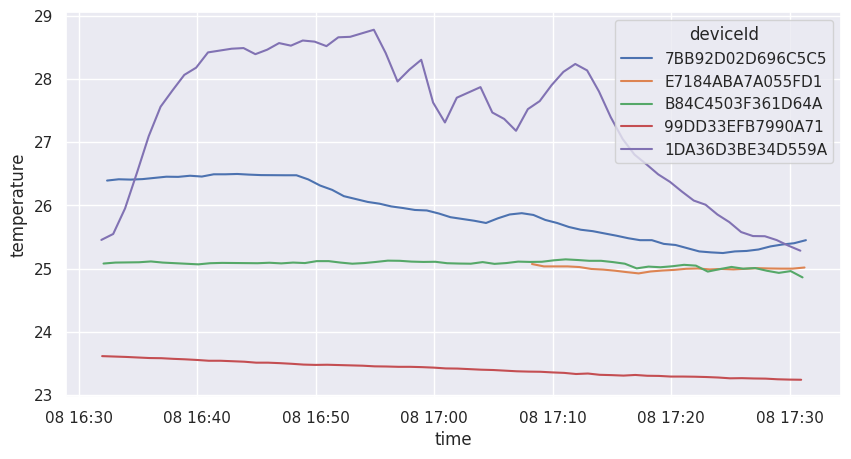

In [138]:
sns.lineplot(df, x='time', y='temperature', hue='deviceId')